In [1]:
#!pip install -q transformers datasets onnxruntime seaborn torch numpy pandas

# Optimize transformers in production on CPU 🛠️

📝 Note: This notebook covers everything you need to know about optimizing a particular transformer model for production on CPU. The knowledge that is used here comes from the HuggingFace documentation, ONNX documentation and chapter 8 "Making Transformers Efficient in Production" from the book "Natural Language Processing with Transformers".

Used materials:
- Model used in this notebook: [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
- Dataset for benchmarking: [SST2 GLUE dataset](https://huggingface.co/datasets/glue)

🤗 HuggingFace provides a wide range of models and datasets that can improve a lot of applications. Be sure to check their website: https://huggingface.co/.

In [2]:
import seaborn as sns
from shutil import rmtree
from datasets import load_dataset, load_metric
import time
import torch.nn as nn
import torch
from transformers.convert_graph_to_onnx import convert
from torch.quantization import quantize_dynamic as torch_quantize_dynamic
import os
from psutil import cpu_count
from tqdm import tqdm
from pathlib import Path
from transformers.convert_graph_to_onnx import convert
import numpy as np
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    pipeline
)
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)
from onnxruntime.quantization import quantize_dynamic as onnx_quantize_dynamic, QuantType
import pandas as pd
import matplotlib.pyplot as plt

#### Defining some standard variables

In [3]:
task = "sentiment-analysis"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
padding = "max_length"
labels_mapping = {"negative": 0, "positive": 1 }
accuracy_score = load_metric('accuracy')
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_dataset = load_dataset("glue", "sst2")
columns = ["name", "average_latency", "std_latency", "accuracy", "size"]
benchmark_results_df = pd.DataFrame(columns=columns)

Reusing dataset glue (C:\Users\Thomas\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 332.90it/s]


#### Utility functions

In [4]:
def label2id(label):
    return labels_mapping.get(label, None)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [5]:
class Benchmarker:
    def __init__(self, name, pipeline, dataset=None) -> None:
        self.name = name
        self.pipeline = pipeline
        self.dataset = dataset
    
    def measure_latency(self, input_data) -> dict:
        latencies = list()
        for _ in range(100):
            self.pipeline(input_data)
        
        for _ in range(1000):
            start_time = time.perf_counter()
            self.pipeline(input_data)
            end_time = time.perf_counter()
            latencies.append((end_time - start_time)*1000)
        
        latencies = np.array(latencies)
        return {"average_latency": np.mean(latencies), "std_latency": np.std(latencies)}
    
    def compute_accuracy(self, dataset=None) -> float:
        if dataset is None:
            dataset = self.dataset
        
        predictions, labels = [], []

        for sample in tqdm(self.dataset):
            prediction = self.pipeline(sample["sentence"])[0]["label"]
            predictions.append(label2id(prediction.lower()))
            labels.append(sample["label"])
        
        return accuracy_score.compute(predictions=predictions, references=labels).get("accuracy")
    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink()
        return size_mb
    
    def run_full_benchmark(self, input_data, dataset=None):
        result = {"name": self.name}
        result.update(self.measure_latency(input_data))
        result["accuracy"] = self.compute_accuracy(dataset) 
        result["size"] = self.compute_size()
        return result
    
    def print_results(self, benchmark_report):
        print(f"BENCHMARK REPORT".center(40, "-"))
        print(f"Name {benchmark_report['name']}")
        print(f"Latency: {benchmark_report['average_latency']:.2f} ms")
        print(f"Accuracy on dataset: {benchmark_report['accuracy'] * 100:.2f}%")
        print(f"Size: {benchmark_report['size']:.2f} MB")
        print(f"".center(40, "-"))

        


## Baseline model

In [6]:
classifier = pipeline(task=task, model=model_name)
benchmarker = Benchmarker(f"baseline-torch", classifier, sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:17<00:00, 49.28it/s]


------------BENCHMARK REPORT------------
Name baseline-torch
Latency: 11.56 ms
Accuracy on dataset: 91.06%
Size: 255.45 MB
----------------------------------------


## Baseline model (quantization)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = (AutoModelForSequenceClassification.from_pretrained(model_name).to("cpu"))

model_quantized = torch_quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [8]:
classifier = pipeline(task=task, model=model_quantized, tokenizer=tokenizer)
benchmarker = Benchmarker(f"baseline-torch-quant", classifier, sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:11<00:00, 74.88it/s]


------------BENCHMARK REPORT------------
Name baseline-torch-quant
Latency: 10.73 ms
Accuracy on dataset: 90.14%
Size: 132.29 MB
----------------------------------------


## Baseline model (ONNX)

In [9]:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
onnx_convert_framework = "pt"
onnx_convert_opset_version = 13
onnx_save_path = "onnx/"
onnx_model_path = Path(f"{onnx_save_path}baseline-ort.onnx")

In [10]:
if os.path.exists(onnx_save_path):
    rmtree(onnx_save_path)
convert(framework=onnx_convert_framework, model=model_name, tokenizer=tokenizer, output=onnx_model_path, opset=onnx_convert_opset_version, pipeline_name=task)

ONNX opset version set to: 13
Loading pipeline (model: distilbert-base-uncased-finetuned-sst-2-english, tokenizer: PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased-finetuned-sst-2-english', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder onnx
Using framework PyTorch: 1.10.1
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


C:\Users\Thomas\miniconda3\envs\cpu_optimized_transformer\lib\site-packages\torch\onnx\utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
C:\Users\Thomas\miniconda3\envs\cpu_optimized_transformer\lib\site-packages\torch\onnx\utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTorch release. The code will work as it is False if models are not larger than 2GB, Otherwise set to False because of size limits imposed by Protocol Buffers.
  warnings.warn("`use_external_data_format' is deprecated and ignored. Will be removed in next "


In [11]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs[pred_idx]}]

In [12]:
class OnnxBenchmarker(Benchmarker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def compute_size(self):
        size_mb = Path(f"onnx/{self.name}.onnx").stat().st_size / (1024 * 1024)
        return size_mb
    
    def compute_accuracy(self, dataset):
        """This overrides the PerformanceBenchmark.compute_accuracy() method"""
        if dataset is None:
            dataset = self.dataset
        
        predictions, labels = [], []

        for sample in tqdm(self.dataset):
            prediction = self.pipeline(sample["sentence"])[0]["label"]
            predictions.append(prediction)
            labels.append(sample["label"])
        
        return accuracy_score.compute(predictions=predictions, references=labels).get("accuracy")

In [13]:
onnx_model = create_model_for_provider(onnx_model_path)
classifier = OnnxPipeline(onnx_model, tokenizer)
benchmarker = OnnxBenchmarker(f"baseline-ort", classifier, sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:19<00:00, 45.81it/s]

------------BENCHMARK REPORT------------
Name baseline-ort
Latency: 7.69 ms
Accuracy on dataset: 91.06%
Size: 255.45 MB
----------------------------------------


## Baseline model (ONNX + quantization)

In [14]:
model_input = onnx_model_path
model_output = f"{onnx_save_path}baseline-ort-quant.onnx"
onnx_quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [15]:
onnx_quantized_model = create_model_for_provider(model_output)
classifier = OnnxPipeline(onnx_quantized_model, tokenizer)
benchmarker = OnnxBenchmarker(f"baseline-ort-quant", classifier, sentiment_dataset["validation"])
benchmark_report = benchmarker.run_full_benchmark("I like you!")
benchmarker.print_results(benchmark_report)
benchmark_results_df = benchmark_results_df.append(benchmark_report, ignore_index=True)

100%|██████████| 872/872 [00:09<00:00, 88.93it/s]

------------BENCHMARK REPORT------------
Name baseline-ort-quant
Latency: 3.64 ms
Accuracy on dataset: 90.37%
Size: 64.10 MB
----------------------------------------


## Wrap-up

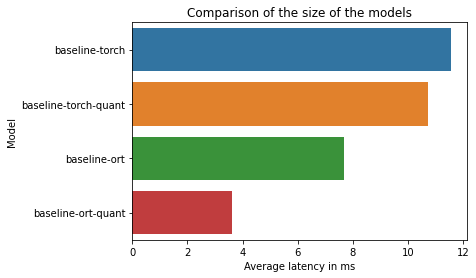

In [16]:
graph = sns.barplot(x="average_latency", y="name", data=benchmark_results_df, order=benchmark_results_df.sort_values('average_latency', ascending=False)["name"], orient="h")
graph.set_title("Comparison of the size of the models")
graph.set_ylabel("Model")
graph.set_xlabel("Average latency in ms")
plt.show()

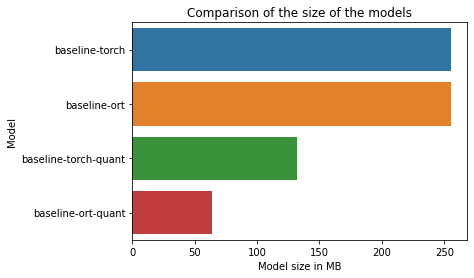

In [17]:
graph = sns.barplot(x="size", y="name", data=benchmark_results_df, order=benchmark_results_df.sort_values('size', ascending=False)["name"], orient="h")
graph.set_title("Comparison of the size of the models")
graph.set_ylabel("Model")
graph.set_xlabel("Model size in MB")
plt.show()

In [18]:
benchmark_results_df

,name,average_latency,std_latency,accuracy,size
0,baseline-torch,11.556954,0.756064,0.910550,255.449937
1,baseline-torch-quant,10.728135,1.091901,0.901376,132.286950
2,baseline-ort,7.694661,0.455093,0.910550,255.449301
3,baseline-ort-quant,3.635198,0.245165,0.903670,64.095174


💨 Conclusion: Techniques such as serving frameworks (e.g. ONNX) and quantization can speed up transformer model inference a lot. The model in this notebook has accelerated almost 4 times compared to the baseline with PyTorch with an accuracy drop < 1%.